# WRAP UP QUIZ
blood_transfusion is a pandas df. The column "Class" contains the target variable. 

In [1]:
import pandas as pd
url = "https://raw.githubusercontent.com/INRIA/scikit-learn-mooc/master/datasets/blood_transfusion.csv"
blood_transfusion = pd.read_csv(url)
data = blood_transfusion.drop(columns="Class")
target = blood_transfusion["Class"]

## Question 1
It is a binary classification because the target is discret made of different classes. The proportions of the class counts are imbalanced: some classes have more than twice as many rows than others. 

In [3]:
target.value_counts()

Class
not donated    570
donated        178
Name: count, dtype: int64

In [4]:
target.unique()

array(['donated', 'not donated'], dtype=object)

## Question 2

Using sklearn.dummy.DummyClassifier and the strategy "most_frequent", what is the average of the accuracy scores obtained by performing a 10-fold cross-validation?

In [11]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_validate

dummy = DummyClassifier(strategy="most_frequent")
cv_results = cross_validate(dummy, data, target, cv=10)
scores = cv_results["test_score"]
print(f"The accuracy of the dummy classifier is: {scores.mean():.3f} +/- {scores.std():.3f}")

The accuracy of the dummy classifier is: 0.762 +/- 0.004


This is not a surprise to get a score a high as ~75%. This is due to the class imbalanced nature of the dataset: always predicting not donated class will be correct ~75% of the time since this the natural proportion of samples belonging to this class in the data.

## Question 3
Repeat the previous experiment but compute the balanced accuracy instead of the accuracy score. Pass scoring="balanced_accuracy" when calling cross_validate or cross_val_score functions, the mean score is:

In [12]:
cv_results_balanced= cross_validate(dummy, data, target, cv=10, scoring="balanced_accuracy")
scores = cv_results_balanced["test_score"]
print(f"The accuracy of the dummy classifier is: {scores.mean():.3f} +/- {scores.std():.3f}")

The accuracy of the dummy classifier is: 0.500 +/- 0.000


In this case, the score is corrected such that such a dummy approach will give a score of 50%. You can learn more about how balanced_accuracy is computed in the scikit-learn documentation. Therefore balanced_accuracy makes it easier to distinguish good from bad classifiers on imbalanced classification problems.

## Question 4
We will use a sklearn.neighbors.KNeighborsClassifier for the remainder of this quiz.

Why is it relevant to add a preprocessing step to scale the data using a StandardScaler when working with a KNeighborsClassifier?

Computing distances on scaled or un-scaled data takes similar time but the resulting distance values could be very different and therefore ordering of which sample is a closest neighbor to which sample also.
For instance: if you have two variables A and B, where A has values which vary between 0 and 1000000 (e.g. the price of a house in euros) and B is a variable that varies between 0 and 30 (e.g. the average outside air temperature in Celsius degrees), then computing distances between rows of such a database will be mostly impacted by the differences in values of the A column and the values of B column will be comparatively ignored.
If one applies StandardScaler to such a database, both the values of A and B will be approximately between -3 and 3 and the neighbor structure will be impacted by both variables.

## Question 5
Create a scikit-learn pipeline (using sklearn.pipeline.make_pipeline) where a StandardScaler will be used to scale the data followed by a KNeighborsClassifier. Use the default hyperparameters.

Inspect the parameters of the created pipeline. What is the value of K, the number of neighbors considered when predicting with the k-nearest neighbors?

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector

num_columns = selector(dtype_exclude ="object")(data)
preprocessor = ColumnTransformer(
    [('num_preprocessor', StandardScaler(), num_columns)]
)

model = make_pipeline(preprocessor, KNeighborsClassifier())
model.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('num_preprocessor', StandardScaler(),
                                    ['Recency', 'Frequency', 'Monetary', 'Time'])])),
  ('kneighborsclassifier', KNeighborsClassifier())],
 'transform_input': None,
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('num_preprocessor', StandardScaler(),
                                  ['Recency', 'Frequency', 'Monetary', 'Time'])]),
 'kneighborsclassifier': KNeighborsClassifier(),
 'columntransformer__force_int_remainder_cols': True,
 'columntransformer__n_jobs': None,
 'columntransformer__remainder': 'drop',
 'columntransformer__sparse_threshold': 0.3,
 'columntransformer__transformer_weights': None,
 'columntransformer__transformers': [('num_preprocessor',
   StandardScaler(),
   ['Recency', 'Frequency', 'Monetary', 'Time'])],
 'columntransformer__verbose': False,
 'columntransformer__verbose_feature_names_out': True,
 'columntransformer

## Question 6
Set n_neighbors=1 in the previous model and evaluate it using a 10-fold cross-validation. Use the balanced accuracy as a score. What can you say about this model? Compare the average of the train and test scores to argument your answer.

In [22]:
model = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=1))

cv_results = cross_validate(
    model, data, target, cv=10, scoring="balanced_accuracy",
    return_train_score=True,
)
cv_results = pd.DataFrame(cv_results)
cv_results[["train_score", "test_score"]].mean()

train_score    0.887998
test_score     0.472747
dtype: float64

## Question 7
We now study the effect of the parameter n_neighbors on the train and test score using a validation curve. You can use the following parameter range:

Also, use a 5-fold cross-validation and compute the balanced accuracy score instead of the default accuracy score (check the scoring parameter). Finally, plot the average train and test scores for the different value of the hyperparameter. We recall that the name of the parameter can be found using model.get_params().

he model underfits for a range of n_neighbors values between 100 to 500 

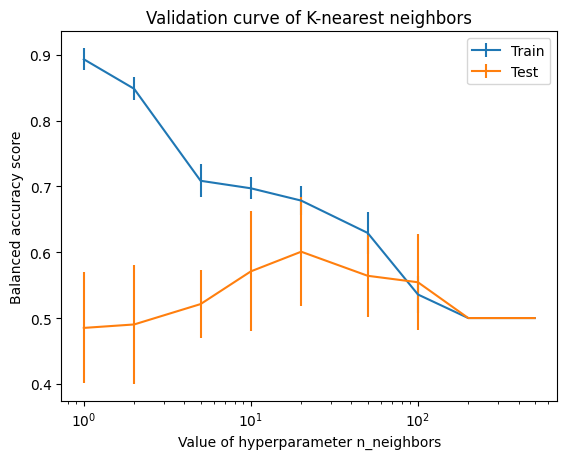

In [27]:
import numpy as np
param_range = np.array([1, 2, 5, 10, 20, 50, 100, 200, 500])

from sklearn.model_selection import ValidationCurveDisplay
disp = ValidationCurveDisplay.from_estimator(
    model,
    data,
    target,
    param_name="kneighborsclassifier__n_neighbors",
    param_range=param_range,
    scoring="balanced_accuracy",
    std_display_style="errorbar",
    n_jobs=2,
)

_ = disp.ax_.set(
    xlabel="Value of hyperparameter n_neighbors",
    ylabel="Balanced accuracy score",
    title="Validation curve of K-nearest neighbors",
)

Underfitting happens when the gap between train and test scores is low and that both scores are low. When n_neighbors is high, underfitting occurs. The model lacks expressivity because it always considers the majority class of a large number of data points. Its prediction tends to be always the same, irrespective of the test point of interest.

## Question 8

The model overfits for a range of n_neighbors values between 1 to 10
Overfitting happens when the gap between train and test scores is high and that the test score is low. When n_neighbors is low, the model looks at small number of data points around the test points of interest. In this case the model is too flexible: it is sensible to noise rather than the underlying structure of the data.

## Question 9

The model best generalizes for a range of n_neighbors values between 10 to 100 

Generalization happens when the gap between train and test scores is relatively low and that the test scores is maximum. In our case, the range between 20 to 50 neighbors seems to be the best. Indeed, for 20 neighbors, the gap between train and test scores is larger than with 50 neighbors; however the test score is better with 20 neighbors.

Considering an intermediate value for n_neighbors makes it possible to limit overfitting by averaging out the influence of a few noisy samples. On the other hand, the model can also avoid underfitting by focusing its decision on the details of a region of interest close to the test sample. The optimum value for n_neighbors is typically very dataset-dependent and can be influenced by the choice of the distance metric, the scaling of the features, the presence of noisy samples, the balance between classes, etc.

Finally notice that, while k-nearest neighbors is useful baseline, it can be too slow to predict on large datasets with many samples and features.
Practitioners would instead favor other models such as gradient boosted trees for instance. On the particular dataset used for this quiz, the best accuracy achieved by the nearest neighbors model does not seem to be high enough to make it useful in practice.
